# Example Downstream Usage: 1000g Figures


Get statistics from 1000g samples, including
  - total samples
  - % matches to each kb individually and metakb as a whole
  - study ids and descriptions by variant hit in metakb

(to be run in a tmp/ directory)

In [1]:
%%capture
%pip install --upgrade --no-cache-dir terra-notebook-utils
%env REPO_DIR=/home/jupyter/vrs_anvil_toolkit

In [2]:
# completes setup for Terra
!cd $REPO_DIR && bash terra/setup.sh

  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.29.0
    Uninstalling requests-2.29.0:
      Successfully uninstalled requests-2.29.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
cromshell 2.0.0 requires google-cloud-bigquery>=3.5.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
getm 0.0.5 requires requests<2.30.0, but you have requests 2.31.0 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.0 which is incompatible.
google-cloud-pubsub 2.18.3 requires grpcio<2.0dev,>=1.51.3, but you have grpcio 1.48.1 which is incompatible.
kfp 2.0.1 r

In [3]:
# creates cohort allele frequency dict, make sure
!python $REPO_DIR/scripts/1000g-processing.py


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
mkdir: cannot create directory ‘/home/jupyter/seqrepo’: File exists
bcftools already installed, not installing
number of metrics files: 23
downloading to /home/jupyter/vrs_anvil_toolkit/tmp/state/20240329_013953:
[SKIPPED] metrics_20240401_144323_189.yaml already exists
[SKIPPED] metrics_20240401_144323_190.yaml already exists
[SKIPPED] metrics_20240401_144323_191.yaml already exists
[SKIPPED] metrics_20240401_144323_192.yaml already exists
[SKIPPED] metrics_20240401_144323_193.yaml already exists
[SKIPPED] metrics_20240401_144323_194.yaml already exists
[SKIPPED] metrics_20240401_144323_195.yaml already exists
[SKIPPED] metrics_20240401_144323_196.yaml already exists
[SKIPPED] metrics_20240401_144323_197.yaml already exists
[SKIPPED] metrics_20240401_144323_198.yaml already exists
[SKIPPED] metrics_20240401_144323_199.yaml already exists
[SKIPPED] metrics_20240401_144323_200.

In [4]:
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import pysam
import seaborn as sns
import subprocess
import yaml

from collections import defaultdict
from google.cloud import storage
from glob import glob
from glom import glom
from firecloud import api as fapi
from re import match
from vrs_anvil import query_metakb
from vrs_anvil.annotator import MATCHES, TOTAL, VRS_OBJECT

In [5]:
# constants to load and save files
figure_dir = "figures"
TIMESTAMP = "20240329_013953"
BASE_DIR = "/home/jupyter/vrs_anvil_toolkit/tmp"

# seaborn styling
sns.set_theme()
sns.set_style("whitegrid")

In [6]:
# read Cohort Allele Frequency (CAF) objects to file
caf_dir = os.path.expanduser(f"{BASE_DIR}/state")
os.makedirs(caf_dir, exist_ok=True)
file_name = f'caf_objects_{TIMESTAMP}.json'

with open(f'{caf_dir}/{file_name}', 'r') as file:
    caf_dicts = json.load(file)

In [7]:
# example formatting of dictionary
print(caf_dicts[0]["id"])
print(caf_dicts[0]["ancillaryResults"]["sample_dict"]['HG00382'])

ga4gh:VA.SOEVGpU16hxYQtJNeRyfq0V-B0rSOGK-
{'study_ids': ['civic.eid:669', 'civic.eid:1757'], 'variant_types': ['germline', 'germline']}


In [8]:
# sorted list of matches to local metakb
sorted_caf_dicts = sorted(caf_dicts, \
                          key=lambda d: d['ancillaryResults']['patient_matches'], \
                           reverse=True)

for caf_dict in sorted_caf_dicts:
    print(f"{caf_dict['label']}: {caf_dict['ancillaryResults']['patient_matches']}")

Overall Cohort Allele Frequency for ga4gh:VA.SPP7r7F_Wb3XbNY8Fawk91yt1U03eIVV (chr19-43551574-T-C): 2952
Overall Cohort Allele Frequency for ga4gh:VA.ZZIGEC0okanDOaqbTEXEWuXNZTrz5qYz (chr20-58903752-C-T): 2746
Overall Cohort Allele Frequency for ga4gh:VA.Zr-4BQqp-pxp9Mh4MDvd7QYuUar72zzV (chr7-87509329-A-G): 2630
Overall Cohort Allele Frequency for ga4gh:VA.0odTBhP86ZeGz6NQASWEnfF1xlUlasC5 (chr12-21176804-A-G): 2629
Overall Cohort Allele Frequency for ga4gh:VA.L2z4yEnWG71RlCd4E6M6TrLldE3gJ6js (chr13-28050157-G-A): 2478
Overall Cohort Allele Frequency for ga4gh:VA.rRPCnh0XXjuePRGWerw6PhVXFYjhchwP (chr1-161509955-A-G): 2214
Overall Cohort Allele Frequency for ga4gh:VA.P3N2rXptujmJHAjSHuuVRe8mivnOz33l (chr11-67585218-A-G): 1857
Overall Cohort Allele Frequency for ga4gh:VA.HMqsRjhwQ9kaXeV7B1QbsgTVdHP1E1ju (chr16-69711242-G-A): 1531
Overall Cohort Allele Frequency for ga4gh:VA.I3ZL5OT1Doq5NGMpvDhgW8jjryE3AjTW (chr19-45351661-T-G): 1321
Overall Cohort Allele Frequency for ga4gh:VA.SOEVGpU16hx

In [9]:
# create function to merge each sample dict from each caf into one dict 
def merge_sample_dict(sample_evidence_dict, allele_id, sample_dict):
    '''update sample evidence for a given allele'''
    
    if allele_id in sample_evidence_dict:
        print(allele_id, "exists, skipping")
        return
    
    for sample, sample_info in sample_dict.items():
        study_ids = sample_info["study_ids"]
        variant_types = sample_info["variant_types"]
        
        if sample not in sample_evidence_dict:
            sample_evidence_dict[sample] = {}

        if "study_ids" in sample_evidence_dict[sample]:
            sample_evidence_dict[sample]["study_ids"].extend(study_ids)
            sample_evidence_dict[sample]["variant_types"].extend(variant_types)
        else:
            sample_evidence_dict[sample]["study_ids"] = list(study_ids)
            sample_evidence_dict[sample]["variant_types"] = list(variant_types)

# create evidence dict for all matches
sample_evidence_dict = defaultdict(list)

for caf_dict in sorted_caf_dicts:
    merge_sample_dict(sample_evidence_dict, caf_dict["id"], caf_dict["ancillaryResults"]["sample_dict"])

16


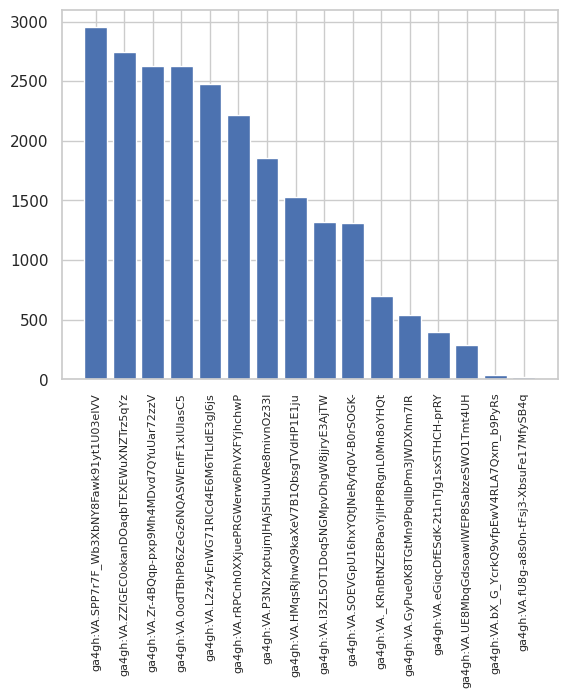

In [10]:
# plot vrs_ids sorted by number of patient matches
num_patients_list = [d['ancillaryResults']['patient_matches'] for d in sorted_caf_dicts]
ids = [d['id'] for d in sorted_caf_dicts]
print(len(ids))
plt.bar(ids, num_patients_list)
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [11]:
# example therapeutic evidence

for d in sorted_caf_dicts[:2]:
    print(f'### {d["id"]} ###')
    for study in d["ancillaryResults"]["metakb_dict"]["studies"]:
        for key in ["id", "type", "direction", "predicate", "therapeutic", "tumorType.label", "strength.label"]:
            v = glom(study, key)
            if key == "therapeutic":
                if "substitutes" in v:
                    print([a["label"] for a in v["substitutes"]])
                elif "components" in v:
                    print([a["label"] for a in v["components"]])
                    
            else:
                print(v)
        
        print("~~~~")
    print()

### ga4gh:VA.SPP7r7F_Wb3XbNY8Fawk91yt1U03eIVV ###
civic.eid:673
VariantTherapeuticResponseStudy
supports
predictsSensitivityTo
['Carboplatin', 'Cisplatin']
Cervical Cancer
clinical cohort evidence
~~~~

### ga4gh:VA.ZZIGEC0okanDOaqbTEXEWuXNZTrz5qYz ###
civic.eid:1995
VariantTherapeuticResponseStudy
supports
predictsResistanceTo
['Erlotinib', 'Gefitinib']
Lung Non-small Cell Carcinoma
clinical cohort evidence
~~~~
civic.eid:2895
VariantTherapeuticResponseStudy
supports
predictsResistanceTo
['Cisplatin', 'Fluorouracil']
Esophageal Cancer
clinical cohort evidence
~~~~



In [12]:
# setup
knowledgebases = ["MOAlmanac", "CIVIC", "All Knowledgebases"]
kb_keywords = ["moa", "civic", ""]  # "" represents match for any knowledgebase

KB, PCT, VAR = range(3)
cols = ["knowledgebase", "percent", "variant_type"]
variant_types = ["germline", "somatic"]
variant_types_set = set(variant_types)
dtypes = [str, float, str]

TOTAL = "all"
num_samples = 3202
variants = sorted(list(variant_types_set)) + [TOTAL]

data = None

# get percentage of patients with variant match by category
for variant_type in variants:
    for i, keyword in enumerate(kb_keywords):
        num_matching_samples = 0

        # increment if sample has matching variant and kb
        for _, id_lists in sample_evidence_dict.items():
            v_types = np.array(id_lists["variant_types"])

            if variant_type == TOTAL:
                study_ids = np.array(id_lists["study_ids"])
            else:
                study_ids = np.array(id_lists["study_ids"])[v_types == variant_type]
            if any(keyword in study_id for study_id in study_ids):
                num_matching_samples += 1


        percent = num_matching_samples * 100.0 / num_samples
        if data is None:
            data = np.array([knowledgebases[i], percent, variant_type])
        else:
            data = np.vstack([data, [knowledgebases[i], percent, variant_type]])
        
expected_num_rows = len(knowledgebases) * len(variants)
assert len(data) == expected_num_rows, f"expected {expected_num_rows} rows, got {len(data)}"

df_pct = pd.DataFrame(data, columns=cols).astype(dtype={col: dtype for col, dtype in zip(cols, dtypes)})
print("Percent of Patients with a Single Variant Match")
df_pct["matching_samples"] = (df_pct["percent"]*num_samples/100).astype(int)

df_display = df_pct.copy()
df_display["percent"] = df_display["percent"].round(2)
df_display.sort_values(by=["knowledgebase", "variant_type"], ascending=[False, True])
df_display[["knowledgebase", "variant_type", "percent", "matching_samples"]].head()

Percent of Patients with a Single Variant Match


,knowledgebase,variant_type,percent,matching_samples
0,MOAlmanac,germline,0.00,0
1,CIVIC,germline,100.00,3202
2,All Knowledgebases,germline,100.00,3202
3,MOAlmanac,somatic,0.00,0
4,CIVIC,somatic,27.76,889


In [13]:
# helper function to add fractional labels to bars on plots
def add_labels(num_bars, ax, vertical_nudge, num_samples, fractional=False, fontsize=8):
    for i, bar in enumerate(ax.patches):
        if i == 0:
            continue
        if i > num_bars:
            break

        height = bar.get_height()
        matching_samples = int(round(height * num_samples))
        
        
        if not fractional:
            label = f"{matching_samples}"
        else:
            label = f"{matching_samples}/{num_samples}"
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height + vertical_nudge
        ax.text(x, y, label, ha="center", va="center", fontsize=fontsize)

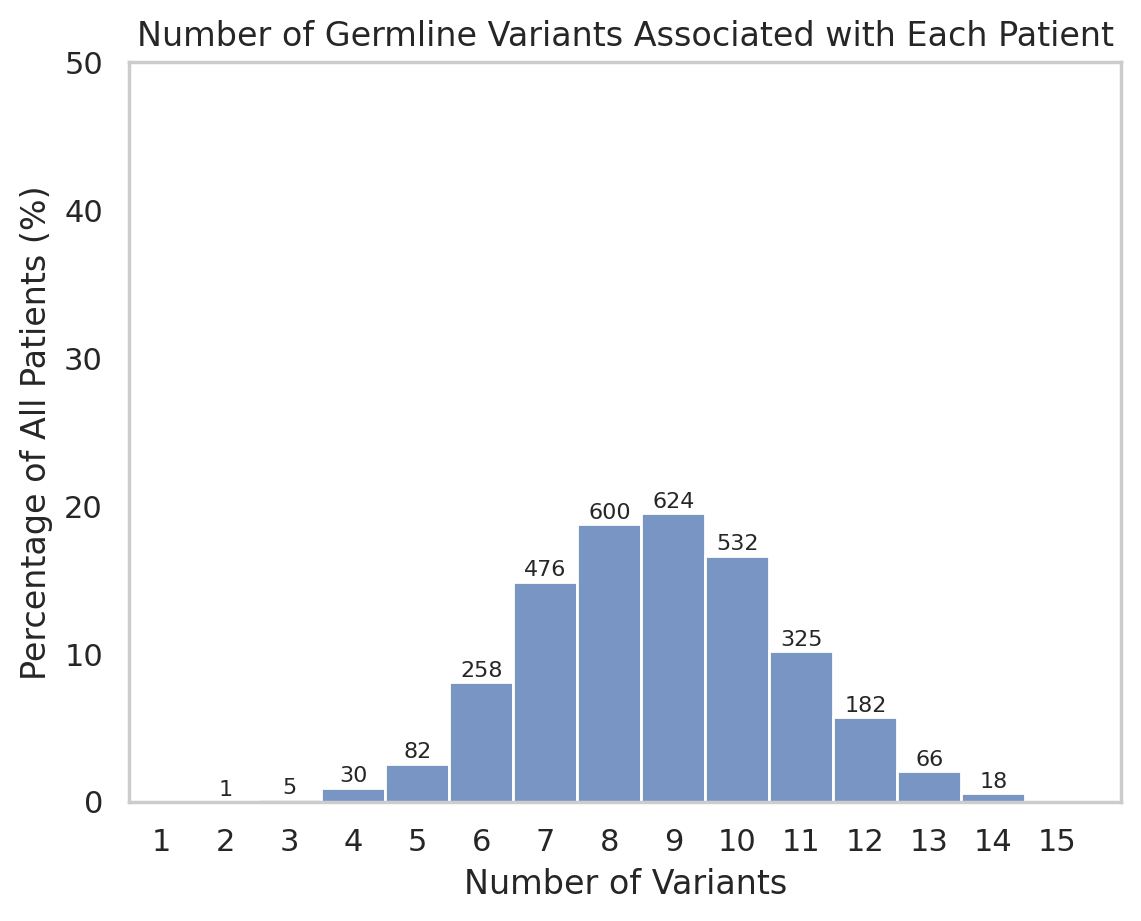

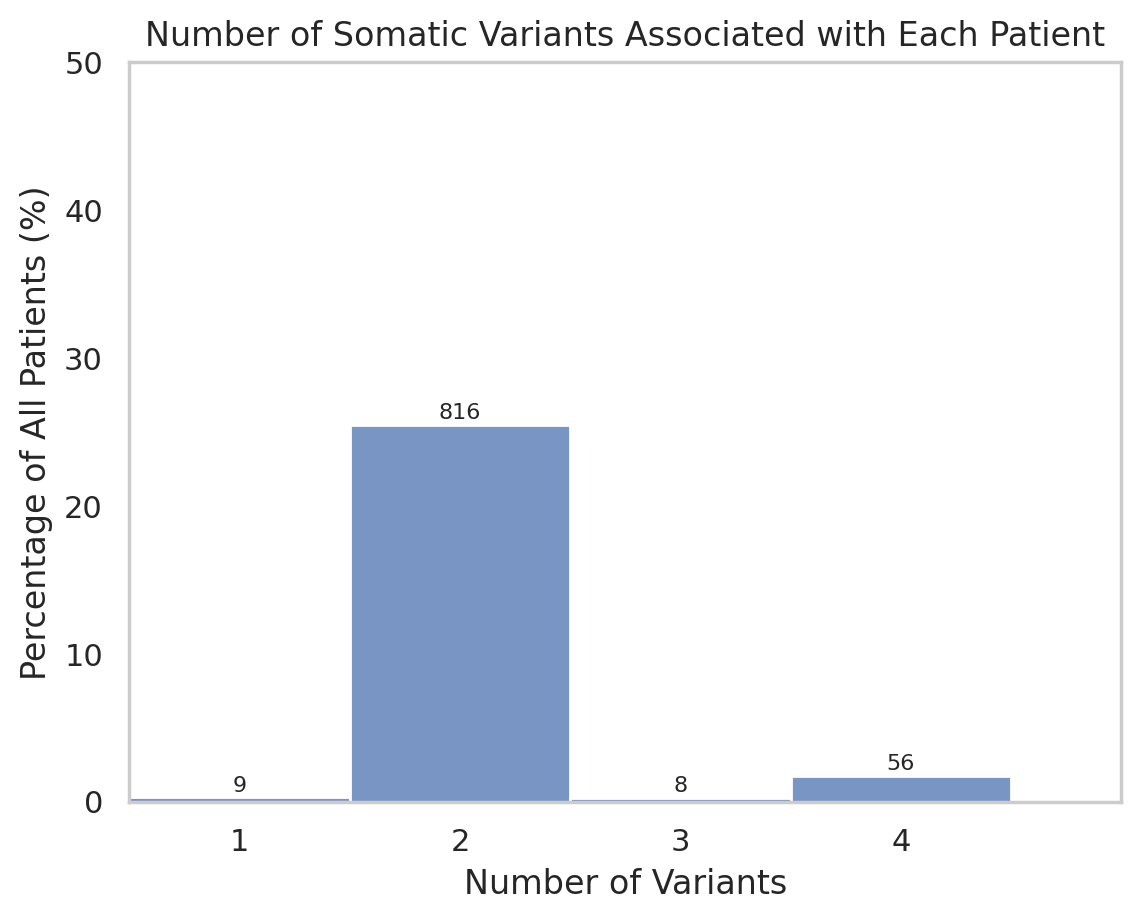

In [14]:
# average number of variants for all samples
num_variant_hits = len([1 for d in sorted_caf_dicts if "metakb_dict" in d["ancillaryResults"]])
jitter = [0.008, .008]


NUM_VARIANTS = "num_variants"

for i, variant_type in enumerate(variant_types):
    num_variants_per_patient = [len( \
        [v for v in values["variant_types"] if v == variant_type or variant_type == TOTAL]) \
        for values in sample_evidence_dict.values()]
        
    num_variants_per_patient.extend([0 for _ in range(num_samples - len(sample_evidence_dict))])
    assert len(num_variants_per_patient) == num_samples, \
    f"only {len(num_variants_per_patient)} samples, expected {num_samples}"
    
    df = pd.DataFrame({NUM_VARIANTS: num_variants_per_patient})
    df["percentage"] = df[NUM_VARIANTS].value_counts(normalize=True) * 100
    
    plt.figure(dpi=200)
    ax = sns.histplot(data=df, x=NUM_VARIANTS, stat="density", discrete=True)
    plt.xlabel("Number of Variants")
    plt.ylabel("Percentage of All Patients (%)")
    plt.title(f"Number of {variant_type.capitalize()} Variants Associated with Each Patient")
    
    add_labels(num_variant_hits, ax, jitter[i], num_samples)

    plt.gca().yaxis.set_major_formatter(lambda x, _: f"{(x*100):.0f}")
    plt.grid(False)
    
    x_lims = (0.5, max((df[NUM_VARIANTS])+1))
    plt.xlim(0.5, max((df[NUM_VARIANTS])+1))
    plt.xticks(range(1, max((df[NUM_VARIANTS])+1)))
    plt.ylim(0, 0.5)

    plt.show()